In [1]:
using Plots, LinearAlgebra

In [2]:
using TimerOutputs

In [3]:
module ZeroAllocationNN
using LinearAlgebra
export ZANN
mutable struct ZANN{T<:AbstractFloat}
    weights :: Vector{Matrix{T}}
    biases :: Vector{Vector{T}}
    
    weighted_inputs :: Vector{Matrix{T}}
    activations :: Vector{Matrix{T}}
        
    nabla_ws :: Vector{Matrix{T}}
    nabla_bs :: Vector{Vector{T}}
    
    function ZANN(::Type{T}, layer_dims) where {T<:AbstractFloat}
        weights = []
        biases = []
        for i = 2:length(layer_dims)
            push!(weights, randn(T, layer_dims[i], layer_dims[i - 1]))
            push!(biases, randn(T, layer_dims[i]))
        end
        return new{T}(
            weights,
            biases,
            Vector{Matrix{T}}(undef, length(layer_dims) - 1),
            Vector{Matrix{T}}(undef, length(layer_dims)),
            Vector{Matrix{T}}(undef, length(layer_dims) - 1),
            Vector{Vector{T}}(undef, length(layer_dims) - 1)
        )
    end
end

sigma(x) = 1 / (1 + exp(-x))
sigma_prime(x) = sigma(x)*(1-sigma(x))

export predict
function predict(nn::ZANN{T}, x :: Matrix{T}) where {T}
    a = x
    for (w, b) in zip(nn.weights, nn.biases)
        a = sigma.(w * a .+ b) # .+ to repeat b along axis 1 (the minibatch size axis)
    end
    return a
end

@views function nabla_ws_from_delta_activations!(nabla_ws :: Array{T, 2}, delta :: Matrix{T}, a :: Matrix{T}) where T<:AbstractFloat
    size(delta, 2) == size(a, 2) || throw(DimensionMismatch("size(A, 2) must equal size(B, 2), found $(size(delta, 2)) and $(size(nn.activations[end-1], 2)) instead"))
    
    tmp = delta[:,1] * a[:,1]' # preallocate
    for i in 1:size(delta, 2)
        @inbounds mul!(tmp, delta[:,i], a[:,i]')
        @. nabla_ws[:,:] += tmp
    end
end

export backprop
function backprop(nn::ZANN{T}, x :: AbstractArray{T, 2}, y :: AbstractArray{T, 2}) where {T}
    # forward pass, the difference from predict is that we save the activations
    # and the weighted inputs
    nn.activations[1] = x

    for (i, (w, b)) in enumerate(zip(nn.weights, nn.biases))
        nn.weighted_inputs[i] = w * nn.activations[i]
        @. nn.weighted_inputs[i] += b
        nn.activations[i+1] = sigma.(nn.weighted_inputs[i])
    end

    # BP1 (Output layer error)
    # Cross-Entropy cost
    
    # TODO(Andrea): finish implementing L2 regularization
    
    delta :: Matrix{T} = (nn.activations[end] - y)

    # BP3 (Cost gradient w.r.t Bias)
    nn.nabla_bs[1] = sum(delta,dims=2)[:,1]

    # BP4 (Cost gradient w.r.t weights)
    tmp = zeros(T, size(delta, 1), size(nn.activations[end-1], 1))
    nabla_ws_from_delta_activations!(tmp, delta, nn.activations[end-1])
    nn.nabla_ws[1] = tmp
    
    for (i, (w, z, a)) in enumerate(Iterators.reverse(zip(
                    nn.weights, nn.weighted_inputs[1:end-1], nn.activations[1:end-2])))
        # BP2 (Previous layer error)
        delta = (w'*delta)
        @. delta *= sigma_prime(z)
        
        nn.nabla_bs[i+1] = sum(delta, dims=2)[:, 1]
        
        tmp = zeros(T, size(delta, 1), size(a, 1))
        nabla_ws_from_delta_activations!(tmp, delta, a)
        nn.nabla_ws[i+1] = tmp
    end
    
    return reverse(nn.nabla_ws), reverse(nn.nabla_bs)
end
end

import Main.ZeroAllocationNN
println("Network creation ")
@time zann = ZeroAllocationNN.ZANN(Float64, [784,100,20,10]);

println("Prediction (expected allocations: $((Base.summarysize(randn(784,100)) + Base.summarysize(randn(100,100)) + Base.summarysize(randn(20,100)) + Base.summarysize(randn(1,100)))/1000))")
ZeroAllocationNN.predict(zann, randn(784, 2))
@time ZeroAllocationNN.predict(zann, randn(784, 100))

println("Backpropagation ")
ZeroAllocationNN.backprop(zann, randn(784, 2), randn(10, 2));
@time ZeroAllocationNN.backprop(zann, randn(784, 100), randn(10, 100));

Network creation 
  0.013057 seconds (2.33 k allocations: 792.900 KiB)
Prediction (expected allocations: 724.16)
  0.003658 seconds (10 allocations: 816.359 KiB)
Backpropagation 
  0.026321 seconds (45 allocations: 2.138 MiB)


---

In [4]:
function accuracy(y_true, y_pred)
    mask = (==).([p for p in eachcol(y_true)], [p for p in eachcol(y_pred)])
    return sum(mask) / length(mask)
end

accuracy (generic function with 1 method)

---

# XOR (Useful for testing)

In [ ]:
module XORUtils

to_xor_onehot(x1, x2) = ifelse((round(Int, x1) ⊻ round(Int, x2)) == 0, [1.0; 0.0], [0.0; 1.0])

function dataset()
    # One-hot encoding
    # [1,0] represents xor = 0
    # [0,1] represents xor = 1
    domain = range(0, stop=1, length=30)
    dataset = vec([([x1, x2], to_xor_onehot(x1, x2)) for x1 in domain, x2 in domain])
    return dataset
end

function traintensor()
    return hcat(map(x->x[1], dataset())...)
end

function trainlabels()
    return hcat(map(x->x[2], dataset())...)
end
    
end
import Main.XORUtils

scatter(map(x->x[1][1], XORUtils.dataset()), map(x->x[1][2], XORUtils.dataset()), color=map(x -> ifelse(x[2] == [1f0;0f0], 1, 2), XORUtils.dataset()), legend=false)

In [ ]:
println("Network creation ")
@time zann = ZeroAllocationNN.ZANN(Float64, [2,40,2,2]);

println("Prediction ")
ZeroAllocationNN.predict(zann, XORUtils.traintensor())
@time ZeroAllocationNN.predict(zann, XORUtils.traintensor())

println("Backpropagation ")
ZeroAllocationNN.backprop(zann, XORUtils.traintensor(), XORUtils.trainlabels());
@time ZeroAllocationNN.backprop(zann, XORUtils.traintensor(), XORUtils.trainlabels());

heatmap(
    range(0, stop=1, length=30),
    range(0, stop=1, length=30),
    (x1, x2) -> sum((ZeroAllocationNN.predict(zann, reshape([x1; x2], 2, :)) - XORUtils.to_xor_onehot(x1, x2)).^2),
    title="Neural Network error surface before training\n(ideally it becomes all black)",
    xlabel="x₁",
    ylabel="x₂",
    clims=(0, 1)
)

### STOCHASTIC GRADIENT DESCENT (minibatch_size = 16)

In [ ]:
epochs = 60_000
minibatch_size = 10
eta = 5e-2

accuracies = Vector{Float64}()

X = XORUtils.traintensor()
Y = XORUtils.trainlabels()
xor_traintensor_len = size(Y, 2)

@time for epoch in 1:epochs 
    begin
        # Obtain minibatch
        minibatch_ixs = rand(1:xor_traintensor_len, minibatch_size)
        x = @view X[:, minibatch_ixs]
        y = @view Y[:, minibatch_ixs]
    end
    
    begin
        # Obtain gradient vectors with backpropagation
        nabla_ws, nabla_bs = ZeroAllocationNN.backprop(zann, x, y)

        # Perform gradient descent using the gradients
        zann.weights -= (eta * nabla_ws / minibatch_size)
        zann.biases -= (eta * nabla_bs / minibatch_size)
    end

    # Calculate accuracy
    if epoch % 1_000 == 0
        # run the predictions over the whole training dataset
        predictions = ZeroAllocationNN.predict(zann, XORUtils.traintensor())
        push!(accuracies, (900 - sum([round.(Int, r) for r in collect(eachcol(predictions))] != [round.(Int, r) for r in collect(eachcol(XORUtils.trainlabels()))])) / 900)
    end
end

plot(
    heatmap(
        range(0, stop=1, length=30),
        range(0, stop=1, length=30),
    #     (x1, x2) -> sum((ZeroAllocationNN.predict(zann, reshape([x1; x2], 2, :)) - XORUtils.to_xor_onehot(x1, x2)).^2),
        (x1, x2) -> ZeroAllocationNN.predict(zann, reshape([x1; x2], 2, :))[1],
        title="Neural Network error surface before training\n(ideally it becomes all black)",
        xlabel="x₁",
        ylabel="x₂",
        clims=(0, 1)
    ),
    heatmap(
        range(0, stop=1, length=30),
        range(0, stop=1, length=30),
    #     (x1, x2) -> sum((ZeroAllocationNN.predict(zann, reshape([x1; x2], 2, :)) - XORUtils.to_xor_onehot(x1, x2)).^2),
        (x1, x2) -> ZeroAllocationNN.predict(zann, reshape([x1; x2], 2, :))[2],
        title="Neural Network error surface before training\n(ideally it becomes all black)",
        xlabel="x₁",
        ylabel="x₂",
        clims=(0, 1)
    )
)


In [ ]:
plot(accuracies, xlabel="epoch", ylabel="accuracy", minorgrid=true, minorticks=5, title="Final train accuracy: $(round(accuracies[end], digits=3))", label=false)

In [ ]:
for (x1, x2) in ((0.1,0.2), (0.9,0.8), (0.1, 0.7), (0.9, 0.2))
    predicted = ZeroAllocationNN.predict(zann, reshape([x1; x2], 2, :))
    expected = XORUtils.to_xor_onehot(x1, x2)
    println("($x1, $x2) => $(round.(predicted,digits=3)) vs $expected")
end

---

## MNIST

In [5]:
using MLDatasets

┌ Info: Precompiling MLDatasets [eb30cadb-4394-5ae3-aed4-317e484a6458]
└ @ Base loading.jl:1278


In [6]:
using ImageCore

┌ Info: Precompiling ImageCore [a09fc81d-aa75-5fe9-8630-4744c3626534]
└ @ Base loading.jl:1278


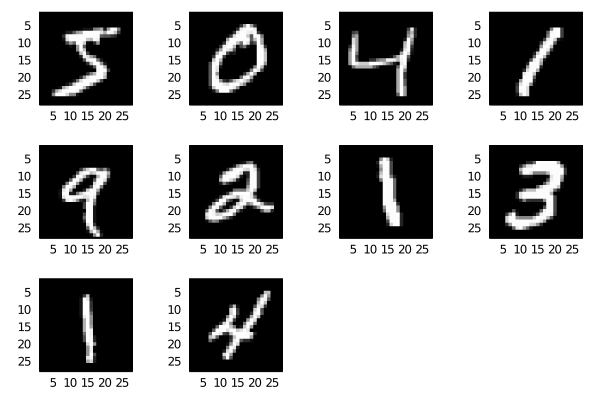

In [7]:
plot([plot(MNIST.convert2image(MNIST.traintensor(i))) for i in 1:10]...)

In [8]:
function to_mnist_onehot(y)
    v = zeros(10)
    v[y+1] = 1.0
    return v
end

to_mnist_onehot (generic function with 1 method)

In [9]:
prepared_mnist_x = reshape(MNIST.traintensor(Float64), 784, :)
prepared_mnist_y = hcat(map(to_mnist_onehot, MNIST.trainlabels())...)

prepared_mnist_x_test = reshape(MNIST.testtensor(Float64), 784, :)
prepared_mnist_y_test = hcat(map(to_mnist_onehot, MNIST.testlabels())...)
nothing

In [10]:
println("Network creation ")
@time zann = ZeroAllocationNN.ZANN(Float64, [784,30,10]);

println("Prediction (expected allocations: $(Base.summarysize(randn(784,60000)) + Base.summarysize(randn(100,60000)) + Base.summarysize(randn(20,60000)) + Base.summarysize(randn(10,60000))))")
ZeroAllocationNN.predict(zann, prepared_mnist_x[:,1:10])
@time ZeroAllocationNN.predict(zann, prepared_mnist_x)

println("Backpropagation ")
ZeroAllocationNN.backprop(zann, prepared_mnist_x[:,1:10], prepared_mnist_y[:,1:10]);
@time ZeroAllocationNN.backprop(zann, prepared_mnist_x, prepared_mnist_y);

Network creation 
  0.000114 seconds (17 allocations: 187.812 KiB)
Prediction (expected allocations: 438720160)
  0.150672 seconds (8 allocations: 36.621 MiB)
Backpropagation 
  2.768115 seconds (35 allocations: 55.298 MiB)


In [11]:
function measure_network_accuracy(nn, prepared_mnist_x_test, prepared_mnist_y_test)
    predictions = ZeroAllocationNN.predict(zann, prepared_mnist_x_test)

    for j in axes(predictions, 2)
        predictions[:, j] = to_mnist_onehot(argmax(vec(predictions[:, j]))-1)
    end
    
    return accuracy(prepared_mnist_y_test, predictions)
end

measure_network_accuracy (generic function with 1 method)

In [12]:
prepared_mnist_x_test = reshape(MNIST.testtensor(Float64), 784, :)
prepared_mnist_y_test = hcat(map(to_mnist_onehot, MNIST.testlabels())...)
println("Initial test accuracy: $(round(measure_network_accuracy(zann, prepared_mnist_x_test, prepared_mnist_y_test), digits=4)) ≈ 0.1 expected")

Initial test accuracy: 0.092 ≈ 0.1 expected


In [13]:
epochs = 30_000
minibatch_size = 10
eta = 5e-1

train_accuracies = Vector{Float64}()
test_accuracies = Vector{Float64}()

reset_timer!()
@timeit "whole training loop" for epoch in 1:epochs 
    # Obtain minibatch
    minibatch_ixs = rand(1:size(prepared_mnist_y, 2), minibatch_size)
    x = prepared_mnist_x[:, minibatch_ixs]
    y = prepared_mnist_y[:, minibatch_ixs]

    # Obtain gradient vectors with backpropagation
    @timeit "backprop step" begin
        nabla_ws, nabla_bs = ZeroAllocationNN.backprop(zann, x, y)

        # Perform gradient descent using the gradients
        zann.weights -= (eta * nabla_ws / minibatch_size)
        zann.biases -= (eta * nabla_bs/ minibatch_size)
    end

    # Calculate accuracy
    @timeit "accuracy calculation" if epoch % 1_000 == 0
        train_acc = measure_network_accuracy(zann, prepared_mnist_x, prepared_mnist_y)
        test_acc = measure_network_accuracy(zann, prepared_mnist_x_test, prepared_mnist_y_test)
        println("[epoch: $epoch] train accuracy: $(round(train_acc, digits=3)), test accuracy: $(round(test_acc, digits=3))")
        push!(train_accuracies, train_acc)
        push!(test_accuracies, test_acc)
    end
end
print_timer()

[epoch: 1000] train accuracy: 0.831, test accuracy: 0.84
[epoch: 2000] train accuracy: 0.882, test accuracy: 0.887
[epoch: 3000] train accuracy: 0.895, test accuracy: 0.901
[epoch: 4000] train accuracy: 0.899, test accuracy: 0.902
[epoch: 5000] train accuracy: 0.914, test accuracy: 0.916
[epoch: 6000] train accuracy: 0.924, test accuracy: 0.924
[epoch: 7000] train accuracy: 0.925, test accuracy: 0.927
[epoch: 8000] train accuracy: 0.93, test accuracy: 0.931
[epoch: 9000] train accuracy: 0.93, test accuracy: 0.927
[epoch: 10000] train accuracy: 0.933, test accuracy: 0.931
[epoch: 11000] train accuracy: 0.933, test accuracy: 0.929
[epoch: 12000] train accuracy: 0.933, test accuracy: 0.93
[epoch: 13000] train accuracy: 0.94, test accuracy: 0.937
[epoch: 14000] train accuracy: 0.939, test accuracy: 0.935
[epoch: 15000] train accuracy: 0.943, test accuracy: 0.94
[epoch: 16000] train accuracy: 0.942, test accuracy: 0.938
[epoch: 17000] train accuracy: 0.945, test accuracy: 0.941
[epoch: 1800

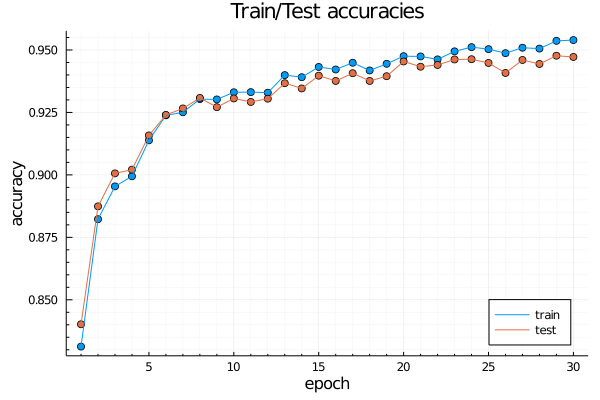

Final test accuracy: 0.9472 ≈ 0.1 expected


In [14]:
println("Final test accuracy: $(round(measure_network_accuracy(zann, prepared_mnist_x_test, prepared_mnist_y_test), digits=4)) ≈ 0.1 expected")

scatter(
    [train_accuracies test_accuracies],
    title="Train/Test accuracies",
    label=false,
    xlabel="epoch", ylabel="accuracy",
    minorgrid=true, minorticks=5,
)
display(plot!(
    [train_accuracies test_accuracies],
    c=[1 2],
    label=["train" "test"],
    legend=:bottomright
))

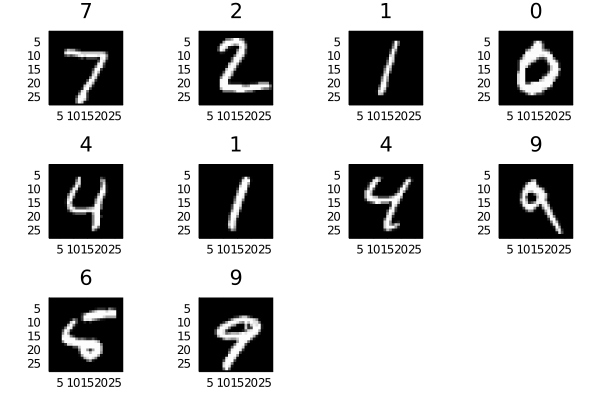

In [29]:
plot([
        plot(
            MNIST.convert2image(MNIST.testtensor(i)),
            title=argmax(ZeroAllocationNN.predict(zann, prepared_mnist_x_test[:, [i]]))[1]-1
        )
        for i in 1:10
    ]...
)